# Project 2

Mael Illien, Jeremy O'Brien, Vanita Thompson

### Assignment:

1. Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.

2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.

3. What can you infer about each of the distinct groups?


### Setup

In [275]:
# Import modules
import networkx as nx
import networkx.algorithms.bipartite as bipartite
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import numpy as np
import io
import requests
from scipy import stats
from pylab import rcParams
import math
%matplotlib inline

### The Dataset: Kaggle IMBD

We will utilize a [Kaggle dataset of movie data](https://www.kaggle.com/PromptCloudHQ/imdb-data/downloads/imdb-data-from-2006-to-2016.zip/1) that uses IMDB as its source. It's limited to the 1000 most popular movies made from 2006-2016 at the time of the author's data pull. 

In [276]:
#read csv into pandas as a dataframe
url="https://raw.githubusercontent.com/Vthomps000/DATA620/master/Movies.csv"
s=requests.get(url).content
imdb=pd.read_csv(io.StringIO(s.decode('utf-8')))

In [277]:
imdb.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


### Data transformation

We transform the data by spliting the Actors column into individual actors and storing the (Movie:Actor) pairs in a data frame.

In [278]:
#separate and pivot csv actor list
#(https://stackoverflow.com/questions/50789834/parse-a-dataframe-column-by-comma-and-pivot-python)
from  itertools import product
mov_actlist = imdb[['Title','Actors']] # Only keep columns on interest
mov_act = mov_actlist.applymap(lambda x: x.split(',') if isinstance (x, str) else [x])
mov_act = pd.DataFrame([j for i in mov_act.values for j in product(*i)], columns=['Movie','Actor'])
mov_act.head(10)

,Movie,Actor
0,Guardians of the Galaxy,Chris Pratt
1,Guardians of the Galaxy,Vin Diesel
2,Guardians of the Galaxy,Bradley Cooper
3,Guardians of the Galaxy,Zoe Saldana
4,Prometheus,Noomi Rapace
5,Prometheus,Logan Marshall-Green
6,Prometheus,Michael Fassbender
7,Prometheus,Charlize Theron
8,Split,James McAvoy
9,Split,Anya Taylor-Joy


We can now create a graph from the data frame.

In [471]:
#G=nx.from_pandas_edgelist(imdb2,'Title','Actors',edge_attr=True)
G=nx.from_pandas_edgelist(mov_act,'Movie','Actor')

Calling info will give us a total number of nodes (number of movies plus number of actors) and edges (total number of movie apperances in the dataset of 1000 movies). We also get average degree, which, in this 2-mode dataset, is a not particularly meaningful mix of average actors listed in the movies in the dataset and average number of the 1000 popular movies in which an actor is listed.

In [472]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 3401
Number of edges: 4035
Average degree:   2.3728


The number of edges matches the number of rows from our dataframe, which matches our expectations. Now, let's do some analysis to prepare for visualization. First, is our graph connected?

In [473]:
nx.is_connected(G)

False

In [474]:
nx.number_connected_components(G)

140

In [475]:
nx.is_bipartite(G)

True

Based on the idea of the 1000 most popular movies from 2006-2016, it seems that our dataset would be connected. Every movie would have a major cast member in at least one other movie, one would think. Maybe there are some foreign films or documentaries that made the list without any crossover from major cast members.

In order to perform more analysis, we need to isolate the connected component. We'll take the largest using subsetting. 

### Connected components and subgraphs

We see from the list below that there are a number of subgraphs in this network, including one very large one of size 2633.

In [476]:
sorted([len(c) for c in nx.connected_components(G) if len(c) > 5], reverse=True)

[2633, 17, 13, 13, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 6, 6]

In [477]:
def get_subgraphs(G):
    #G_connected_list = list(nx.connected_component_subgraphs(G))
    #G_connected_list = [G.subgraph(c) for c in nx.connected_components(G)] # networkx 2.4
    subgraphs = [(G.subgraph(c),len(c)) for c in nx.connected_components(G) if len(c) > 5] # networkx 2.4
    return sorted(subgraphs, key = lambda x: x[1], reverse=True)

In [478]:
#Create connected subgraphs
subgraphs = get_subgraphs(G)
subgraphs[:5]

[(<networkx.classes.graph.Graph at 0x1306e32d0>, 2633),
 (<networkx.classes.graph.Graph at 0x1306e35d0>, 17),
 (<networkx.classes.graph.Graph at 0x1306e3190>, 13),
 (<networkx.classes.graph.Graph at 0x12ecae450>, 13),
 (<networkx.classes.graph.Graph at 0x1306e3cd0>, 9)]

In [479]:
#Isolate the largest subgraph
#G_connected = G_connected_list[0]
#print(nx.info(G_connected))
largest_subg = subgraphs[0][0]
print(nx.info(largest_subg))

Name: 
Type: Graph
Number of nodes: 2633
Number of edges: 3395
Average degree:   2.5788


In [480]:
#Isolate the second largest subgraph
#G_connected_2 = G_connected_list[1]
#print(nx.info(G_connected_2))
print(nx.info(subgraphs[1][0]))

Name: 
Type: Graph
Number of nodes: 17
Number of edges: 16
Average degree:   1.8824


In [481]:
#Isolate the third largest subgraph
G_connected_3 = G_connected_list[2]
print(nx.info(subgraphs[2][0]))

Name: 
Type: Graph
Number of nodes: 13
Number of edges: 12
Average degree:   1.8462


We will just go with the largest subgraph, which we'll rename G.

In [482]:
#Verify bipartite
G=largest_subg
print('Is this graph bipartite: {} \nIs this graph connected: {}'.format(nx.is_bipartite(G),nx.is_connected(G)))
print(nx.info(G))

Is this graph bipartite: True 
Is this graph connected: True
Name: 
Type: Graph
Number of nodes: 2633
Number of edges: 3395
Average degree:   2.5788


### Visualization

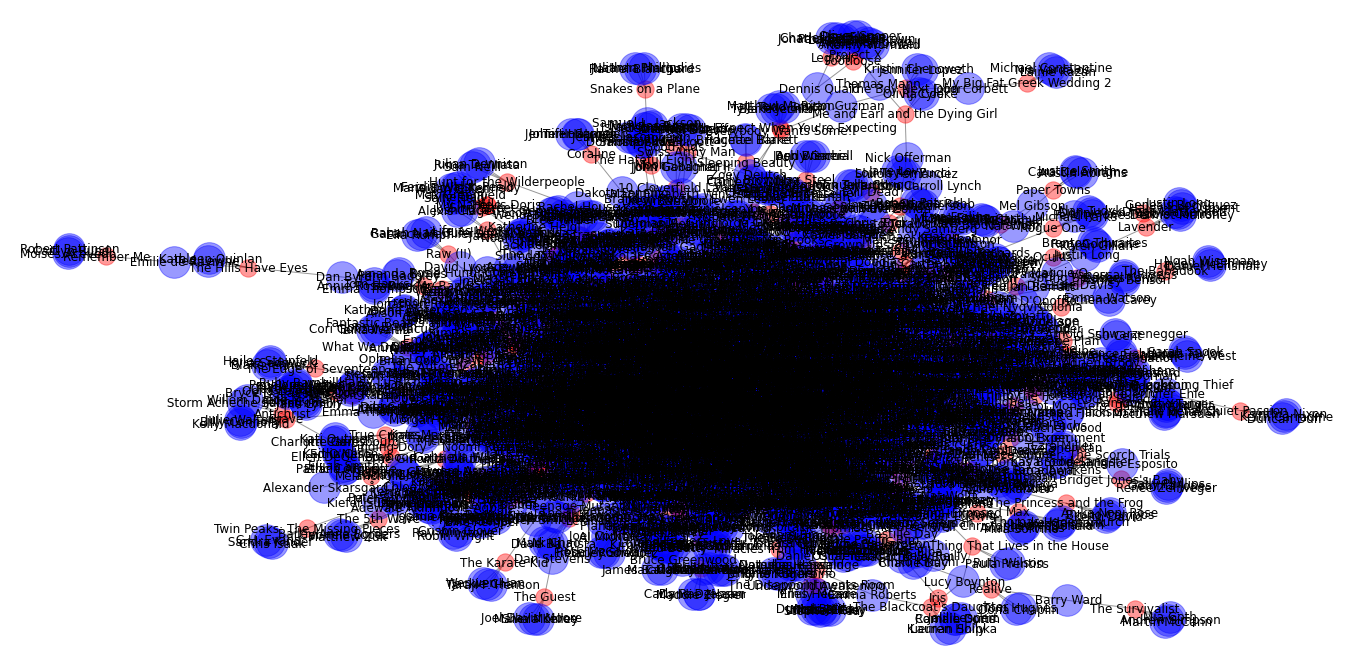

In [483]:
import warnings
warnings.filterwarnings("ignore")
Titles, Actors = nx.bipartite.sets(G)
# Visualize the 2-mode networks
plt.rcParams["figure.figsize"] = (24,12)
plt.axis('off')
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=Titles, node_color='red', alpha = 0.4)
nx.draw_networkx_nodes(G, pos, nodelist=Actors, node_color='blue', alpha = 0.4, node_size = 1000)
nx.draw_networkx_edges(G, pos, alpha = 0.4)
nx.draw_networkx_labels(G, pos);

The network is a hairball, it's huge. We need to trim it down. In order to do so, we will project the two-node network as a one-node network and use the island method which uses a degree centrality threshold to trim off less connected nodes. The procedure below will iterative a number of times until a meaningful thresholf is selected. 

### Unipartite projection 

In [484]:
G_act = bipartite.projected_graph(G, Actors)
G_mov = bipartite.projected_graph(G, Titles)
print(nx.info(G_act))
print(nx.info(G_mov))

Name: 
Type: Graph
Number of nodes: 1786
Number of edges: 4915
Average degree:   5.5039
Name: 
Type: Graph
Number of nodes: 847
Number of edges: 3505
Average degree:   8.2763


### Actors network

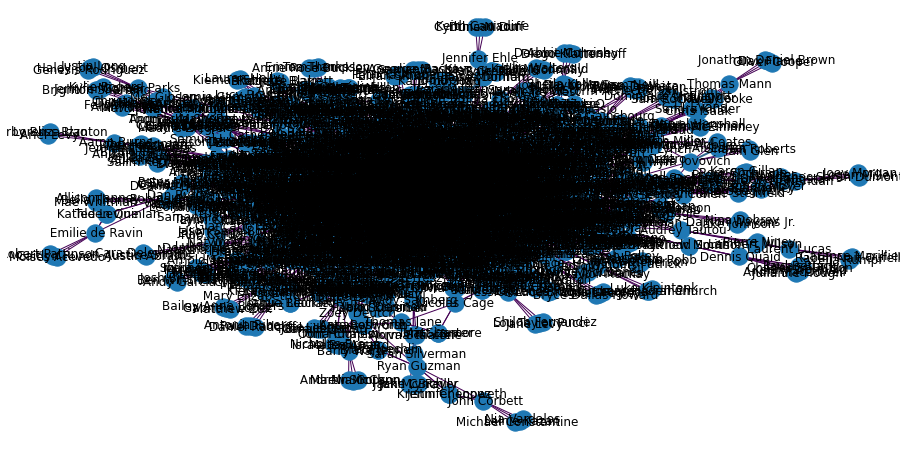

In [485]:
# Visualize the unipartite graph to identify relationships between women.
actors = bipartite.weighted_projected_graph(G, Actors, ratio=False)
weights = [edata['weight'] for f,t,edata in actors.edges(data=True)]
plt.rcParams["figure.figsize"] = (16,8)
nx.draw_networkx(actors, k=0.1,iterations=20, width=weights, edge_color=weights)
plt.axis('off')
plt.show()

### Movies network

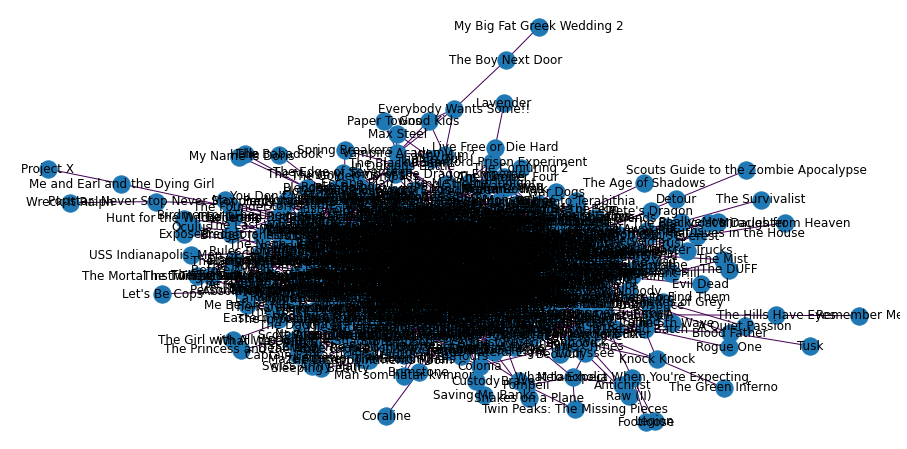

In [486]:
# Visualize the unipartite graph to identify relationships between women.
movies = bipartite.weighted_projected_graph(G, Titles, ratio=False)
weights = [edata['weight'] for f,t,edata in movies.edges(data=True)]
plt.rcParams["figure.figsize"] = (16,8)
nx.draw_networkx(movies, k=0.1,iterations=20, width=weights, edge_color=weights)
plt.axis('off')
plt.show()

### The island method

The two functions below define the island method procedure. Elaborate

In [487]:
def trim_nodes(g, degree=1):
    g2=g.copy() #copy graph so that original is not altered adn to avoid error below
    for (node, val) in g.degree(): #must be run on original graph or dictionary will change size during iteration
            if val < degree:
                g2.remove_node(node)
    return g2

In [488]:
def trim_edges(g, weight=1): 
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True): 
        if edata['weight'] > weight:
            g2.add_edge(f,to,**edata)
    return g2

In [489]:
def island_method(g, func=trim_nodes, iterations=5):

    degree = [val for (node, val) in g.degree()]
    
    mn=int(min(degree))
    mx=int(max(degree))
    step=int((mx-mn)/(iterations))
    # A list of threshold and trimmed graph pairs
    islands = [[deg_threshold, func(g, deg_threshold)] for deg_threshold in range(mn,mx,step)]

    for i in islands:
        g_trim = i[1]
        num_nodes = len(g_trim.nodes)
        i.append(num_nodes)
        #num_subgraphs = len(list(nx.connected_component_subgraphs(item[1])))
        num_subgraphs = len([g_trim.subgraph(c) for c in nx.connected_components(g_trim)]) # networkx 2.4
        i.append(num_subgraphs)
    
    return pd.DataFrame(islands, columns = ['Degree Threshold', 'Graph','Number of Nodes', 'Number of Subgraphs'])


In [490]:
import warnings
def draw_islands(df, i):
    warnings.filterwarnings("ignore")
    
    G = df['Graph'][i]
    H = df['Graph'][0]
    #node_size = [float(H.degree(v))*100 for v in H] #sizes nodes according to connectedness in first iteration
    node_size = [G.degree(v)*100 for v in G] #sizes nodes according to connectedness in first iteration
    plt.rcParams.update({'font.size': 22})

    plt.rcParams["figure.figsize"] = (24,12)
    plt.axis('off')
    
    title = str("Island Method Iteration # %d\nThreshold for Inclusion: %s Shared Movie Credits in Database" % (i, df['Degree Threshold'][i]))
    plt.title(title)
    
    ## Include code to make edges thicker, color
    
    pos=nx.spring_layout(G)
    nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, alpha=0.8)
    nx.draw_networkx_labels(G, pos=pos, font_size=18, alpha = 0.9)

### Actors revisited

In [491]:
act_islands = island_method(G_act, func=trim_nodes, iterations=8)
act_islands.drop(['Graph'], axis=1)

,Degree Threshold,Number of Nodes,Number of Subgraphs
0,2,1786,1
1,5,695,1
2,8,351,5
3,11,208,3
4,14,122,5
5,17,55,5
6,20,32,5
7,23,18,4
8,26,8,7
9,29,2,2


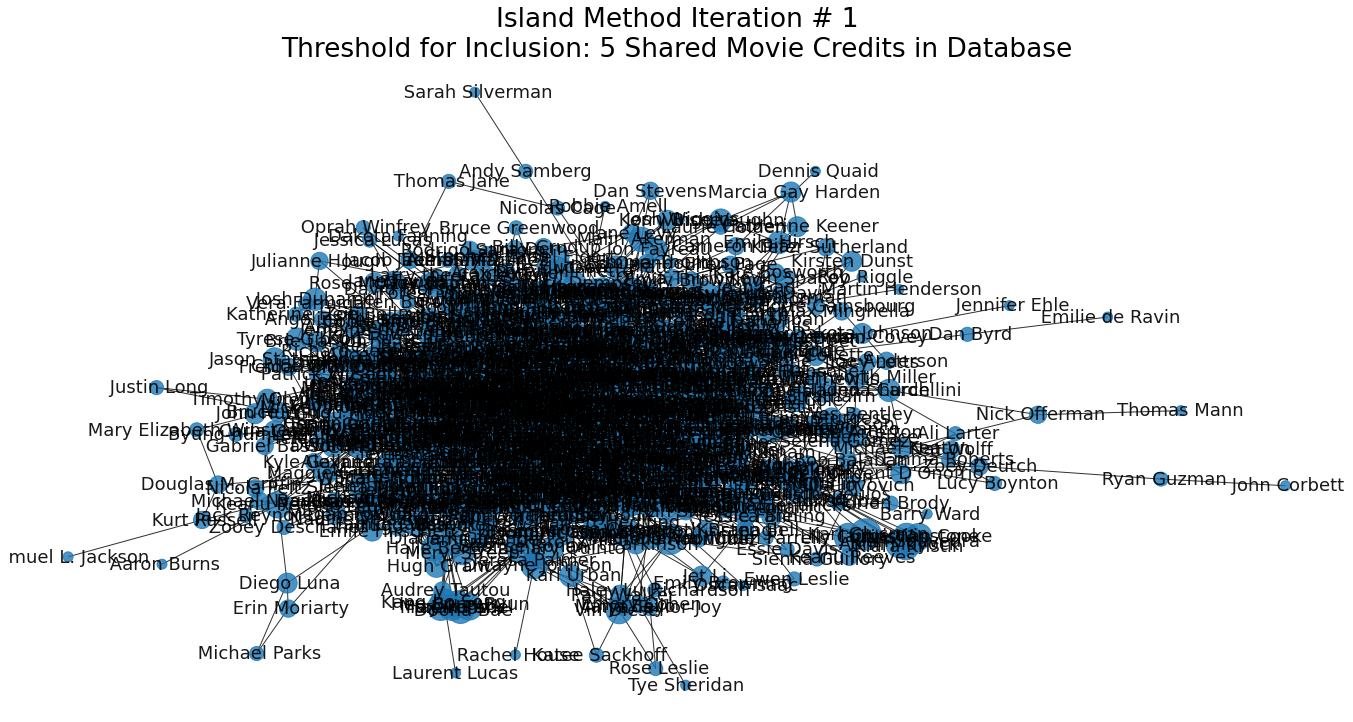

In [492]:
draw_islands(act_islands,1)

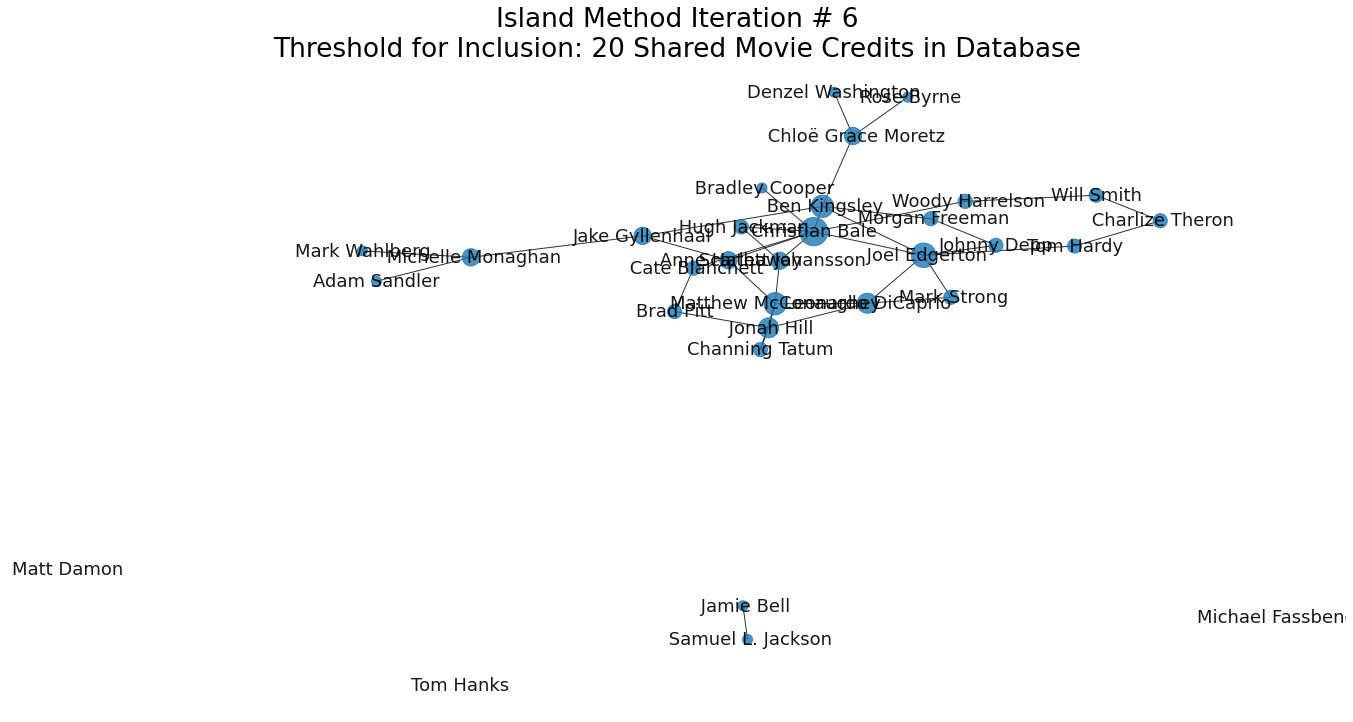

In [493]:
draw_islands(act_islands,6)

Justify choice of threshold

In [495]:
small_actors = act_islands['Graph'][1]
print(nx.info(small_actors))

Name: 
Type: Graph
Number of nodes: 695
Number of edges: 2200
Average degree:   6.3309


### Movies revisited

In [496]:
mov_islands = island_method(G_mov, func=trim_nodes, iterations=8)
mov_islands.drop(['Graph'], axis=1)

,Degree Threshold,Number of Nodes,Number of Subgraphs
0,1,847,1
1,4,685,2
2,7,507,1
3,10,325,1
4,13,160,1
5,16,73,1
6,19,23,5
7,22,7,4
8,25,4,2


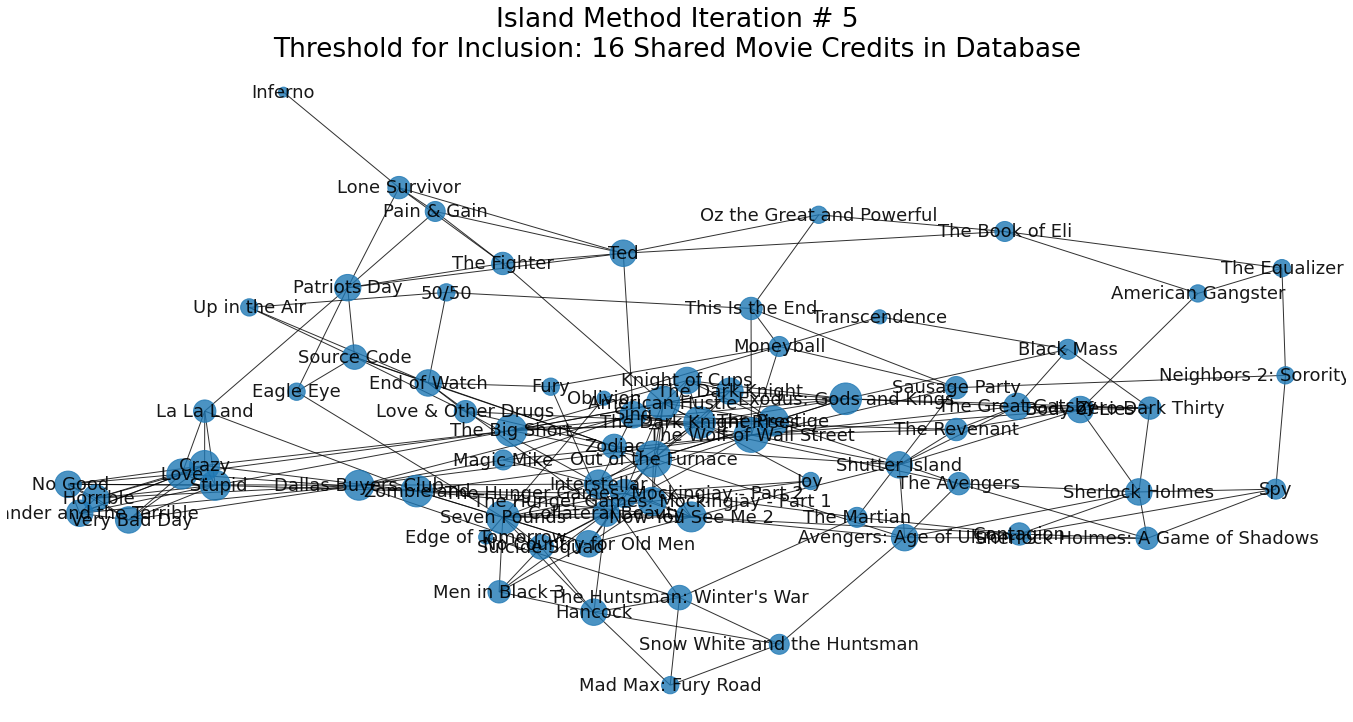

In [498]:
draw_islands(mov_islands,5)

In [499]:
small_movies = mov_islands['Graph'][5]
print(nx.info(small_movies))

Name: 
Type: Graph
Number of nodes: 73
Number of edges: 222
Average degree:   6.0822


### Centrality


In [500]:
def sortSecond(val):
    return val[1]

In [501]:
from operator import itemgetter as ig

def sorted_map(map):
    ms = sorted(map.items(), key=ig(1), reverse=True)
    return ms

In [502]:
G = small_actors
d=dict(G.degree())
ds=sorted_map(d)
ds[:10]

[('Christian Bale', 26),
 ('Mark Wahlberg', 22),
 ('Matthew McConaughey', 22),
 ('Leonardo DiCaprio', 22),
 ('Will Smith', 21),
 ('Denzel Washington', 20),
 (' Jonah Hill', 20),
 (' Rose Byrne', 19),
 (' Scarlett Johansson', 19),
 ('Johnny Depp', 19)]

Degrees here simply captures the number of times a node appears in the dataset. So Wahlberg's in the most of the top 1000 movies from 2006-2016. Between bad action movies and some surprise hit comedies, this makes sense. Movies would show up here only if they had larger casts included in the dataset.

In [503]:
c=nx.closeness_centrality(G)
cs=sorted_map(c)
cs[:10]

[('Christian Bale', 0.33969652471855116),
 (' Joel Edgerton', 0.3204062788550323),
 ('Leonardo DiCaprio', 0.3196683555964993),
 ('Matthew McConaughey', 0.31922723091076355),
 (' Jonah Hill', 0.3187873220027561),
 (' Scarlett Johansson', 0.318348623853211),
 (' Woody Harrelson', 0.31473922902494333),
 (' Michelle Monaghan', 0.3131768953068592),
 (' Ben Kingsley', 0.31275349256421814),
 ('Denzel Washington', 0.31261261261261264)]

Closeness centrality measures a node's ability to communicate with others. In our book's example, these are the gossip mongers. 

From a movie industry perspective, this would be a node's ability to reach all other nodes in the network with fewest edges. Notice that, whereas our distance measure of centers highlighted mostly movies, here we get almost all actors.

In [504]:
b=nx.betweenness_centrality(G)
bs=sorted_map(b)
bs[:10]

[('Christian Bale', 0.05067482678367901),
 ('Mark Wahlberg', 0.04126291516795457),
 (' Jonah Hill', 0.03771172957195608),
 ('Leonardo DiCaprio', 0.03634245028651074),
 ('Matthew McConaughey', 0.03463334794397516),
 (' Chloë Grace Moretz', 0.03082831319437672),
 (' Rose Byrne', 0.03054305220594439),
 (' Charlize Theron', 0.029791892363284344),
 ('Will Smith', 0.029393901687042145),
 ('Denzel Washington', 0.028497009843454664)]

Betweenness centrality, according to our textbook, is based on the idea that power resides in bottlenecks between networks. So a cross-genre actor like Hugh Jackman who appears in action films, musicals, and romantic comedies might be an important connector to different groups of actors.

Summing our centrality measures up:

In [505]:
#from pg. 54

names1=[x[0] for x in ds[:10]]
names2=[x[0] for x in cs[:10]]
names3=[x[0] for x in bs[:10]]

names=list(set(names1) | set(names2) | set(names3))
table=[[name,d[name],c[name],b[name]] for name in names]
print(pd.DataFrame(table, columns=['actor','degree','closeness','betweeness']))

                  actor  degree  closeness  betweeness
0            Jonah Hill      20   0.318787    0.037712
1       Woody Harrelson      17   0.314739    0.023492
2           Johnny Depp      19   0.289287    0.022536
3          Ben Kingsley      16   0.312753    0.021857
4            Rose Byrne      19   0.301477    0.030543
5     Leonardo DiCaprio      22   0.319668    0.036342
6   Matthew McConaughey      22   0.319227    0.034633
7            Will Smith      21   0.308719    0.029394
8       Charlize Theron      17   0.301085    0.029792
9        Christian Bale      26   0.339697    0.050675
10    Denzel Washington      20   0.312613    0.028497
11    Michelle Monaghan      16   0.313177    0.027676
12   Chloë Grace Moretz      17   0.308307    0.030828
13        Mark Wahlberg      22   0.308994    0.041263
14   Scarlett Johansson      19   0.318349    0.028122
15        Joel Edgerton      17   0.320406    0.025502


The odd-man out here is probably Sharlto Copley, but a quick glance at his IMDB page reveals why his weird resume makes him a connector between a wide variety of actors.

Now let's look at eigenvector measurements, a metric that captures degree centrality. This looks to detect what the book calls "gray cardinals" by weighting connections to well-connected nodes more than the less ones.

In [506]:
e=nx.eigenvector_centrality_numpy(G)
es=sorted_map(e)
es[:10]

[('Christian Bale', 0.22053219355772186),
 ('Matthew McConaughey', 0.16325466803441205),
 ('Leonardo DiCaprio', 0.16092686412349763),
 (' Scarlett Johansson', 0.1406277179577145),
 (' Joel Edgerton', 0.13496664092600705),
 (' Woody Harrelson', 0.13256424687017043),
 (' Anne Hathaway', 0.1317293729212976),
 (' Jonah Hill', 0.13092042574207255),
 ('Will Smith', 0.11642856375013906),
 (' Mark Strong', 0.11553215942215415)]

Here we see a possible issue with our data import - the commas in the title of the movie Crazy, Stupid, Love led to duplicate records for that movie and likely cause the cast to have overrated measures here. 

Let's separate the modes.

### Cliques

We see what we'd expect - the edges now are between actors in the same movie rather than actors and movies in which they star.

We will now look at groupings, first using the built-in find_cliques function and then using a modified version of the island method described in the book.

In [526]:
#trimmed = trim_edges(small_actors,4)
#cliques = list(nx.find_cliques(trimmed))

In [527]:
list(nx.find_cliques(small_actors))[:30]

[[' Rebel Wilson', ' Hailee Steinfeld', 'Anna Kendrick'],
 [' Rebel Wilson', ' Mark Strong', 'Sacha Baron Cohen'],
 [' Rebel Wilson', ' Alison Brie', ' Leslie Mann', 'Dakota Johnson'],
 ['Kang-ho Song',
  ' Hee-Bong Byun',
  ' Doona Bae',
  ' Hae-il Park',
  ' Max Irons',
  'Saoirse Ronan',
  ' Jake Abel',
  ' Diane Kruger'],
 [' Cameron Diaz', ' Rose Byrne', ' Jamie Foxx'],
 [' Cameron Diaz', ' Penélope Cruz', 'Michael Fassbender'],
 [' William Hurt', 'Edward Norton', ' Liv Tyler', ' Tim Roth'],
 [' William Hurt', 'Kevin Costner'],
 [' Nadine Velazquez', 'Denzel Washington', ' John Goodman'],
 [' Nadine Velazquez', ' Erin Moriarty'],
 [' Eric Stonestreet', ' Kevin Hart'],
 [' Eric Stonestreet', ' Wentworth Miller', ' James Marsden', 'Karl Urban'],
 [' Ellen Burstyn', ' Rachel Weisz', 'Hugh Jackman'],
 ['Malin Akerman', ' Michelle Monaghan', 'Ben Stiller'],
 ['Malin Akerman', ' Carla Gugino', ' Patrick Wilson'],
 [' Lin Shaye', ' Rose Byrne', 'Patrick Wilson', ' Ty Simpkins'],
 [' Jane

In [528]:
list(nx.find_cliques(small_movies))[:30]

[['Avengers: Age of Ultron', 'Now You See Me 2', 'Zodiac', 'Shutter Island'],
 ['Avengers: Age of Ultron',
  'Sherlock Holmes',
  'Sherlock Holmes: A Game of Shadows',
  'The Avengers'],
 ['Avengers: Age of Ultron', 'Snow White and the Huntsman'],
 ['Love & Other Drugs', 'The Dark Knight Rises', 'Interstellar'],
 ['Love & Other Drugs', 'Zodiac', 'End of Watch', 'Source Code'],
 ['Spy', 'Contagion', 'Sherlock Holmes: A Game of Shadows', 'Sherlock Holmes'],
 ['Spy', 'Neighbors 2: Sorority Rising'],
 ['Body of Lies', 'Sherlock Holmes', 'Zero Dark Thirty'],
 ['Body of Lies', 'American Gangster'],
 ['Body of Lies',
  'The Great Gatsby',
  'The Wolf of Wall Street',
  'The Revenant',
  'Shutter Island'],
 ['Body of Lies', 'The Great Gatsby', 'Zero Dark Thirty'],
 ['Men in Black 3',
  'Seven Pounds',
  'Hancock',
  'Collateral Beauty',
  'Suicide Squad'],
 ['Men in Black 3', 'Seven Pounds', 'No Country for Old Men'],
 ['Oz the Great and Powerful', 'The Book of Eli', 'Ted'],
 ['Oz the Great an

Much of these cliques are just the casts listed for a film. Let's use our version of the island method to find some true islands. Beyond a single degree, will we just see the casts of franchise films, or might we see director-specific cliques?

As a reminder, our starting dataset for analysis is itself as subgraph, so we've already "raised the water" slightly.

Because degree has a different real-life meaning for each node type in the bipartite graph (how many movies an actor has starred in versus how many cast members a movie has), we have tested a modified version of the "island method" on the projected, actors-only graph. 

The '''degree_island_method''' function removes nodes in an iterative, step-wise fashion, increasing the threshold for minimum degree necessary to remain in the graph each time. It differs from the version given in the text because our graph does not have edge weights. 

Interestingly, most of the levels have only one subgraph, suggesting that there is one, main clique.

We can now write a brief function to draw all of the graphs with some custom formatting and labels. We will map node size to degree for easier reading. Note: While in the bipartite graph, and actor's degree indicated the number of movies they starred in, the the '''G_act''' projected graph, it indicates the number of other actors with whom they've shared a credit in the database. So, more movies ***and*** more diverse casting or casting in larger ensembles will all increase the degree.

In the graph above, for actors who have been in at least 27 movies, we see a densely connected graph of well-known actors and--all by himself--Tom Hanks. 

What this means is that Tom Hanks has at least 2 degrees of separation from anyone in the central subgraph. Someone get that guy in a movie with Denzel!

### Conclusion
